In [0]:
%matplotlib inline

[Reference Video](https://youtu.be/Rv3osRZWGbg)


Spatial Transformer Networks Tutorial
=====================================
**Author**: [Ghassen HAMROUNI](https://github.com/GHamrouni)

![img1](https://pytorch.org/tutorials/_images/FSeq.png)

## How to augment your network using a visual attention mechanism called Spatial Transformer Networks!

More : [DeepMind paper](https://arxiv.org/abs/1506.02025)

### Spatial transformer networks(STN)
- a generalization of differentiable attention to any spatial transformation

- allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model


For example, it can crop a region of interest, scale and correct the orientation of an image. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.

> One of the best things about STN is the ability to simply plug it into any existing CNN with very little modification.



In [0]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

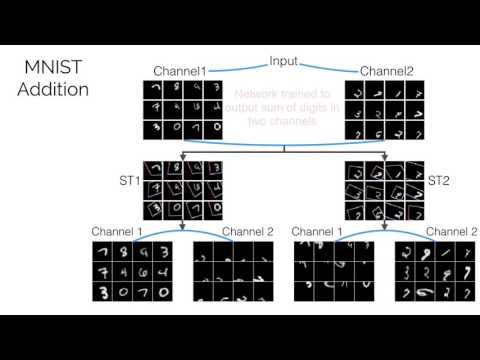

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('yGFVO2B8gok', width=600, height=400)

Loading the data
----------------

Experiment with the classic MNIST dataset. 

Using a standard convolutional network augmented with a spatial transformer
network.



In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 16384/9912422 [00:00<01:15, 131370.18it/s]

9920512it [00:00, 31402082.29it/s]                           


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 466925.16it/s]
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6539316.59it/s]                            
8192it [00:00, 139357.06it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

1. The localization network

 *  a regular CNN which regresses the
   transformation parameters. 
 * The transformation is never learned explicitly from this dataset.
 * Instead, the network learns automatically the spatial transformations that enhances the global accuracy.

2. The grid generator
 *  generate a grid of coordinates in the input image corresponding to each pixel from the output image.


3. The sampler
 * use the parameters of the transformation and applies
   it to the input image.

![img2](https://pytorch.org/tutorials/_images/stn-arch.png)



> Note :
   We need the latest version of PyTorch that contains
   `affine_grid` and `grid_sample` modules.


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        # More about Affine Matrix -> https://youtu.be/il6Z5LCykZk
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        #[64, 10, 3, 3]
        xs = xs.view(-1, 10 * 3 * 3)
        #[64, 90]
        theta = self.fc_loc(xs)
        #[64, 6]
        theta = theta.view(-1, 2, 3)
        #[64, 2, 3]
        

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
# nll을 쓰는 이유 -> log_softmax

model = Net().to(device)

In [0]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

Training the model
------------------

Now, let's use the SGD algorithm to train the model. 

The network is learning the classification task in a supervised way.

In the same time the model is learning STN automatically in an end-to-end fashion.



In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) #The negative log likelihood loss -> https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

![대체 텍스트](https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log_demo.png)

Visualizing the STN results
---------------------------

>Inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the transformations while training.



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.342889
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.984685


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2207, Accuracy: 9388/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.497848
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.293976

Test set: Average loss: 0.1411, Accuracy: 9566/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.271983
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.177090

Test set: Average loss: 0.0896, Accuracy: 9728/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.202441
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.232467

Test set: Average loss: 0.0814, Accuracy: 9748/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.098782
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.118462

Test set: Average loss: 0.0641, Accuracy: 9800/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.109976
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.166232

Test set: Average loss: 0.0735, Accuracy: 9761/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.220744
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.137127

Test set: Average loss: 0.0589, Accuracy: 9813/10000 (98%)

Tra

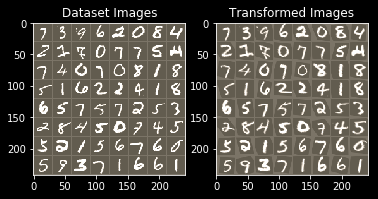

In [0]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
         
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
with plt.style.context('dark_background'):
  visualize_stn()

  plt.ioff()
  plt.show()